In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import os
import zipfile
from datetime import datetime
import time

# Dataset class
class EmbeddingDataset(Dataset):
    def __init__(self, csv_file, num_classes=3):
        self.data = pd.read_csv(csv_file, header=0)
        self.num_classes = num_classes
        self.classes = ['Pastos', 'planta_daninha', 'planta_toxicas']
        self.class_to_idx = {self.classes[i]: i for i in range(num_classes)}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label_str, embedding_str = self.data.iloc[idx]
        label = self.class_to_idx[label_str]
        embedding = np.fromstring(embedding_str.strip('[]'), sep=' ')
        embedding = torch.tensor(embedding, dtype=torch.float32)
        return embedding, label

# Model definition
class EmbeddingClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EmbeddingClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def plot_fold_history(fold_histories, output_dir):
    """Plot training history for all folds"""
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    for fold, history in enumerate(fold_histories):
        plt.plot(history['train_loss'], label=f'Train Fold {fold+1}')
        plt.plot(history['val_loss'], label=f'Val Fold {fold+1}', linestyle='--')
    plt.title('Model Loss by Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    for fold, history in enumerate(fold_histories):
        plt.plot(history['train_acc'], label=f'Train Fold {fold+1}')
        plt.plot(history['val_acc'], label=f'Val Fold {fold+1}', linestyle='--')
    plt.title('Model Accuracy by Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.close()

def plot_fold_metrics(fold_scores, output_dir):
    """Plot final metrics for each fold"""
    plt.figure(figsize=(10, 6))
    folds = range(1, len(fold_scores) + 1)
    plt.bar(folds, fold_scores)
    plt.axhline(y=np.mean(fold_scores), color='r', linestyle='--', label='Mean')
    
    plt.title('Accuracy by Fold')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    
    for i, v in enumerate(fold_scores):
        plt.text(i + 1, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'fold_metrics.png'))
    plt.close()

def plot_confusion_matrix(y_true, y_pred, classes, output_dir):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.close()

def save_results(fold_scores, classification_rep, fold_times, total_time, output_dir):
    """Save results to text files"""
    with open(os.path.join(output_dir, 'fold_accuracies.txt'), 'w') as f:
        f.write("Results by Fold:\n")
        for i, (score, time_taken) in enumerate(zip(fold_scores, fold_times)):
            f.write(f"Fold {i+1}:\n")
            f.write(f"  Accuracy: {score:.4f}\n")
            f.write(f"  Training time: {time_taken:.2f} seconds ({time_taken/60:.2f} minutes)\n")
        
        f.write(f"\nMean Accuracy: {np.mean(fold_scores):.4f}")
        f.write(f"\nAccuracy Standard Deviation: {np.std(fold_scores):.4f}")
        f.write(f"\n\nAverage time per fold: {np.mean(fold_times):.2f} seconds ({np.mean(fold_times)/60:.2f} minutes)")
        f.write(f"\nTotal training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

    with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
        f.write(classification_rep)

def create_zip_archive(output_dir, zip_filename):
    """Create zip archive with all results"""
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, arcname)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=100):
    """Train the model and return training history"""
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Record history
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_correct / train_total)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_correct / val_total)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Train Acc: {train_correct/train_total:.4f}, '
                  f'Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Acc: {val_correct/val_total:.4f}')
    
    return history

def main():
    # Parameters
    csv_file = '../../embeddings_with_augmentation.csv'
    k_folds = 10
    epochs = 100
    batch_size = 32
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'resultados_kfold_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Load dataset
    print("Loading data...")
    dataset = EmbeddingDataset(csv_file)
    input_dim = dataset[0][0].shape[0]
    
    # Initialize K-Fold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Storage for metrics
    fold_histories = []
    fold_scores = []
    fold_times = []
    all_predictions = []
    all_true_labels = []
    
    # Record total training time
    total_start_time = time.time()
    
    # K-Fold Cross Validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(dataset)))):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 20)
        
        # Create data loaders for this fold
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
        
        # Initialize model, criterion, and optimizer
        model = EmbeddingClassifier(input_dim=input_dim, num_classes=len(dataset.classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train the model
        fold_start_time = time.time()
        history = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)
        fold_time = time.time() - fold_start_time
        
        # Evaluate the model
        model.eval()
        val_correct = 0
        val_total = 0
        fold_predictions = []
        fold_true_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                fold_predictions.extend(predicted.cpu().numpy())
                fold_true_labels.extend(labels.cpu().numpy())
        
        # Record metrics
        fold_acc = val_correct / val_total
        print(f"Fold {fold + 1} - Accuracy: {fold_acc:.4f}")
        print(f"Training time: {fold_time:.2f} seconds ({fold_time/60:.2f} minutes)")
        
        fold_histories.append(history)
        fold_scores.append(fold_acc)
        fold_times.append(fold_time)
        all_predictions.extend(fold_predictions)
        all_true_labels.extend(fold_true_labels)
    
    # Calculate total training time
    total_time = time.time() - total_start_time
    
    # Generate and save final results
    print("\nGenerating reports and visualizations...")
    
    # Classification Report
    report = classification_report(all_true_labels, all_predictions, 
                                 target_names=dataset.classes, digits=4)
    print("\nClassification Report:")
    print(report)
    
    # Generate all visualizations and save results
    plot_fold_history(fold_histories, output_dir)
    plot_fold_metrics(fold_scores, output_dir)
    plot_confusion_matrix(all_true_labels, all_predictions, dataset.classes, output_dir)
    save_results(fold_scores, report, fold_times, total_time, output_dir)
    
    # Create zip file with all results
    zip_filename = f'resultados_kfold_{timestamp}.zip'
    create_zip_archive(output_dir, zip_filename)
    
    print(f"\nCross Validation Results:")
    print(f"Mean accuracy: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")
    print(f"Average time per fold: {np.mean(fold_times):.2f} seconds ({np.mean(fold_times)/60:.2f} minutes)")
    print(f"Total training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print(f"\nAll results have been saved to '{zip_filename}'")

if __name__ == "__main__":
    main()

Loading data...

Fold 1/10
--------------------


C:\Users\FelipeYathe\AppData\Local\Temp\ipykernel_39832\2698411145.py:30: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  embedding = np.fromstring(embedding_str.strip('[]'), sep=' ')
C:\Users\FelipeYathe\AppData\Local\Temp\ipykernel_39832\2698411145.py:30: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  embedding = np.fromstring(embedding_str.strip('[]'), sep=' ')


Epoch [10/100], Train Loss: 0.8432, Train Acc: 0.6351, Val Loss: 0.7671, Val Acc: 0.6892
Epoch [20/100], Train Loss: 0.8239, Train Acc: 0.6291, Val Loss: 0.8322, Val Acc: 0.7027
Epoch [30/100], Train Loss: 0.8174, Train Acc: 0.6441, Val Loss: 0.8025, Val Acc: 0.6622
Epoch [40/100], Train Loss: 0.8112, Train Acc: 0.6381, Val Loss: 0.8791, Val Acc: 0.6622
Epoch [50/100], Train Loss: 0.8089, Train Acc: 0.6246, Val Loss: 0.7143, Val Acc: 0.6622
Epoch [60/100], Train Loss: 0.7950, Train Acc: 0.6396, Val Loss: 0.8350, Val Acc: 0.7027
Epoch [70/100], Train Loss: 0.7962, Train Acc: 0.6321, Val Loss: 0.8268, Val Acc: 0.6757
Epoch [80/100], Train Loss: 0.7843, Train Acc: 0.6381, Val Loss: 0.8245, Val Acc: 0.6757
Epoch [90/100], Train Loss: 0.7586, Train Acc: 0.6441, Val Loss: 0.9237, Val Acc: 0.6892
Epoch [100/100], Train Loss: 0.7678, Train Acc: 0.6366, Val Loss: 0.8109, Val Acc: 0.6757
Fold 1 - Accuracy: 0.6757
Training time: 11.09 seconds (0.18 minutes)

Fold 2/10
--------------------
Epoch [

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import os
import zipfile
from datetime import datetime
import time
import copy

classes = ['Pastos', 'planta_daninha', 'planta_toxicas']

class EmbeddingDataset(Dataset):
    def __init__(self, csv_file, num_classes=3):
        self.data = pd.read_csv(csv_file, header=0)
        self.num_classes = num_classes
        self.class_to_idx = {classes[i]: i for i in range(num_classes)}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label_str, embedding_str = self.data.iloc[idx]
        label = self.class_to_idx[label_str]
        embedding = np.fromstring(embedding_str.strip('[]'), sep=' ')
        embedding = torch.tensor(embedding, dtype=torch.float32)
        return embedding, label

class EmbeddingClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EmbeddingClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def plot_fold_history(histories, output_dir):
    """
    Plota o histórico de treinamento para todos os folds
    """
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for fold, history in enumerate(histories):
        plt.plot(history['train_acc'], label=f'Treino Fold {fold+1}')
        plt.plot(history['val_acc'], label=f'Val Fold {fold+1}', linestyle='--')
    plt.title('Acurácia do Modelo por Fold')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for fold, history in enumerate(histories):
        plt.plot(history['train_loss'], label=f'Treino Fold {fold+1}')
        plt.plot(history['val_loss'], label=f'Val Fold {fold+1}', linestyle='--')
    plt.title('Perda do Modelo por Fold')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.close()

def plot_fold_metrics(fold_scores, output_dir):
    """
    Plota as métricas finais de cada fold em um gráfico de barras
    """
    plt.figure(figsize=(10, 6))
    folds = range(1, len(fold_scores) + 1)
    plt.bar(folds, fold_scores)
    plt.axhline(y=np.mean(fold_scores), color='r', linestyle='--', label='Média')
    
    plt.title('Acurácia por Fold')
    plt.xlabel('Número do Fold')
    plt.ylabel('Acurácia')
    plt.ylim([0, 1])
    
    for i, v in enumerate(fold_scores):
        plt.text(i + 1, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'fold_metrics.png'))
    plt.close()

def plot_confusion_matrix(y_true, y_pred, output_dir):
    """
    Plota e salva a matriz de confusão
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.close()

def save_results(fold_scores, classification_rep, fold_times, total_time, output_dir):
    """
    Salva os resultados em arquivos de texto
    """
    with open(os.path.join(output_dir, 'fold_accuracies.txt'), 'w') as f:
        f.write("Resultados por Fold:\n")
        for i, (score, time_taken) in enumerate(zip(fold_scores, fold_times)):
            f.write(f"Fold {i+1}:\n")
            f.write(f"  Acurácia: {score:.4f}\n")
            f.write(f"  Tempo de treinamento: {time_taken:.2f} segundos ({time_taken/60:.2f} minutos)\n")
        
        f.write(f"\nMédia de Acurácia: {np.mean(fold_scores):.4f}")
        f.write(f"\nDesvio Padrão de Acurácia: {np.std(fold_scores):.4f}")
        f.write(f"\n\nTempo médio por fold: {np.mean(fold_times):.2f} segundos ({np.mean(fold_times)/60:.2f} minutos)")
        f.write(f"\nTempo total de treinamento: {total_time:.2f} segundos ({total_time/60:.2f} minutos)")

    with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
        f.write(classification_rep)

def create_zip_archive(output_dir, zip_filename):
    """
    Cria um arquivo zip com todos os resultados
    """
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, arcname)

def train_evaluate_fold(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    """
    Treina e avalia o modelo para um fold específico
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Record history
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_correct / train_total)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_correct / val_total)
        
    return history, val_correct / val_total

def main():
    # Configurações
    csv_file = '../../embeddings_with_augmentation.csv'
    k_folds = 10
    num_epochs = 100
    batch_size = 32
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Criar diretório para resultados
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'resultados_kfold_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Carregar dataset
    print("Carregando dados...")
    dataset = EmbeddingDataset(csv_file)
    input_dim = dataset[0][0].shape[0]
    
    # Inicializar K-Fold
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Métricas e históricos
    fold_histories = []
    fold_scores = []
    fold_times = []
    all_predictions = []
    all_true_labels = []
    
    # Marca o início do treinamento total
    total_start_time = time.time()
    
    # Loop através dos folds
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 20)
        
        # Preparar dataloaders
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
        
        # Inicializar modelo, critério e otimizador
        model = EmbeddingClassifier(input_dim, len(classes)).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Marca o início do treinamento do fold
        fold_start_time = time.time()
        
        # Treinar e avaliar o fold
        history, fold_accuracy = train_evaluate_fold(
            model, train_loader, val_loader, criterion, optimizer, device, num_epochs
        )
        
        # Calcular o tempo do fold
        fold_time = time.time() - fold_start_time
        fold_times.append(fold_time)
        
        # Coletar predições para a matriz de confusão
        model.eval()
        fold_preds = []
        fold_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                fold_preds.extend(predicted.cpu().numpy())
                fold_labels.extend(labels.numpy())
        
        all_predictions.extend(fold_preds)
        all_true_labels.extend(fold_labels)
        
        # Armazenar resultados
        fold_histories.append(history)
        fold_scores.append(fold_accuracy)
        
        print(f"Fold {fold + 1} - Acurácia: {fold_accuracy:.4f}")
        print(f"Tempo de treinamento do fold: {fold_time:.2f} segundos ({fold_time/60:.2f} minutos)")
    
    # Calcular o tempo total de treinamento
    total_time = time.time() - total_start_time
    
    # Gerar relatório de classificação
    report = classification_report(all_true_labels, all_predictions, 
                                 target_names=classes, digits=4)
    
    # Gerar visualizações e salvar resultados
    print("\nGerando relatórios e visualizações...")
    plot_fold_history(fold_histories, output_dir)
    plot_fold_metrics(fold_scores, output_dir)
    plot_confusion_matrix(all_true_labels, all_predictions, output_dir)
    save_results(fold_scores, report, fold_times, total_time, output_dir)
    
    # Criar arquivo zip
    zip_filename = f'resultados_kfold_{timestamp}.zip'
    create_zip_archive(output_dir, zip_filename)
    
    print(f"\nResultados da Validação Cruzada:")
    print(f"Acurácia média: {np.mean(fold_scores):.4f} (+/- {np.std(fold_scores):.4f})")
    print(f"Tempo médio por fold: {np.mean(fold_times):.2f} segundos ({np.mean(fold_times)/60:.2f} minutos)")
    print(f"Tempo total de treinamento: {total_time:.2f} segundos ({total_time/60:.2f} minutos)")
    print(f"\nTodos os resultados foram salvos em '{zip_filename}'")

if __name__ == "__main__":
    main()

Carregando dados...

Fold 1/10
--------------------


C:\Users\FelipeYathe\AppData\Local\Temp\ipykernel_39832\3445039694.py:31: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  embedding = np.fromstring(embedding_str.strip('[]'), sep=' ')


Fold 1 - Acurácia: 0.7027
Tempo de treinamento do fold: 7.26 segundos (0.12 minutos)

Fold 2/10
--------------------
Fold 2 - Acurácia: 0.5811
Tempo de treinamento do fold: 7.68 segundos (0.13 minutos)

Fold 3/10
--------------------
Fold 3 - Acurácia: 0.6892
Tempo de treinamento do fold: 8.20 segundos (0.14 minutos)

Fold 4/10
--------------------
Fold 4 - Acurácia: 0.6757
Tempo de treinamento do fold: 7.24 segundos (0.12 minutos)

Fold 5/10
--------------------
Fold 5 - Acurácia: 0.5676
Tempo de treinamento do fold: 7.53 segundos (0.13 minutos)

Fold 6/10
--------------------
Fold 6 - Acurácia: 0.6622
Tempo de treinamento do fold: 7.43 segundos (0.12 minutos)

Fold 7/10
--------------------
Fold 7 - Acurácia: 0.5676
Tempo de treinamento do fold: 8.74 segundos (0.15 minutos)

Fold 8/10
--------------------
Fold 8 - Acurácia: 0.6622
Tempo de treinamento do fold: 8.55 segundos (0.14 minutos)

Fold 9/10
--------------------
Fold 9 - Acurácia: 0.6351
Tempo de treinamento do fold: 8.75 seg

C:\Users\Lipe Marlon\AppData\Local\Temp\ipykernel_8236\2134724123.py:26: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  embedding = np.fromstring(embedding_str.strip('[]'), sep=' ')


Epoch 1/25, Train Loss: 1.1111, Train Acc: 0.1800, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 2/25, Train Loss: 1.1057, Train Acc: 0.2400, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 3/25, Train Loss: 1.1090, Train Acc: 0.2300, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 4/25, Train Loss: 1.1110, Train Acc: 0.1400, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 5/25, Train Loss: 1.1077, Train Acc: 0.2600, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 6/25, Train Loss: 1.1071, Train Acc: 0.2900, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 7/25, Train Loss: 1.1069, Train Acc: 0.2700, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 8/25, Train Loss: 1.1073, Train Acc: 0.2300, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 9/25, Train Loss: 1.1066, Train Acc: 0.2400, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 10/25, Train Loss: 1.1070, Train Acc: 0.2500, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 11/25, Train Loss: 1.1032, Train Acc: 0.2500, Test Loss: 1.1195, Test Acc: 0.1689
Epoch 12/25, Train Loss: 1.1027, Train Ac

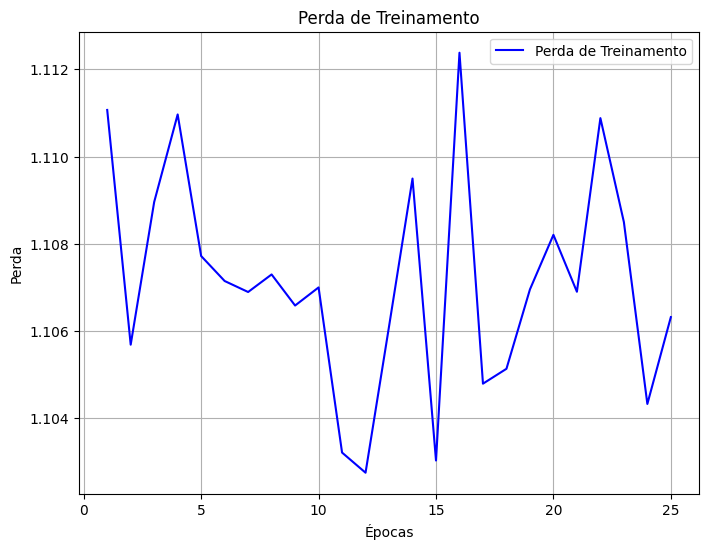

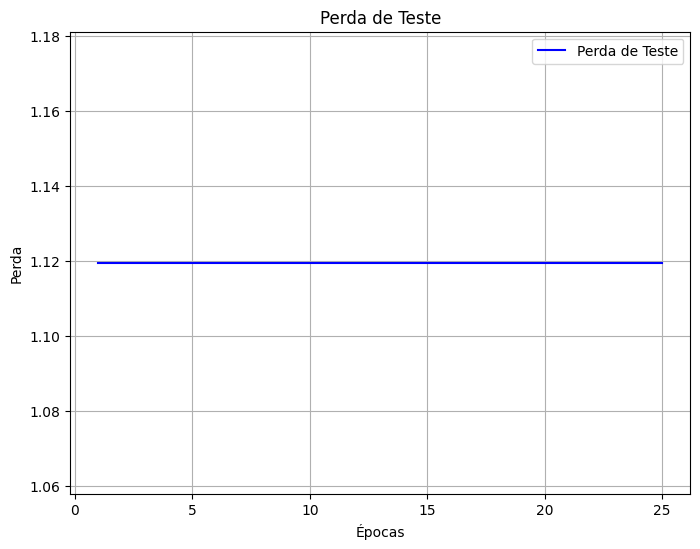

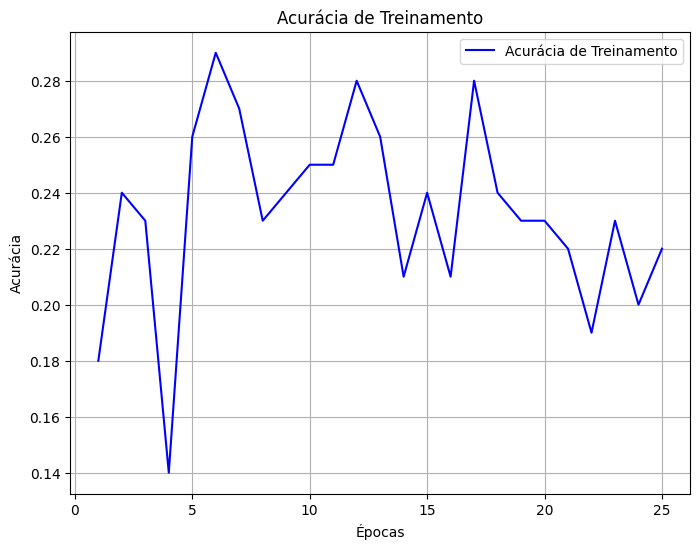

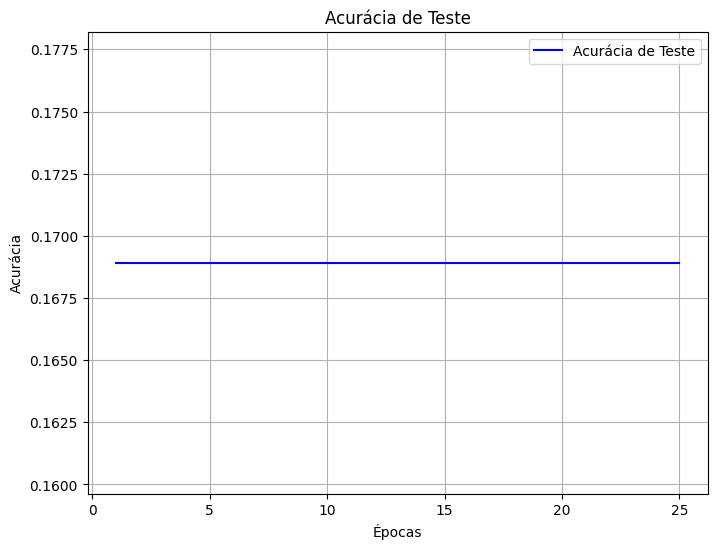

Accuracy on the new task or domain: 16.89%


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt


################### SIX SHOT #########


# Definir as classes esperadas
classes = ['Pastos', 'planta_daninha', 'planta_toxicas']  

# Definir um Dataset personalizado para lidar com embeddings
class EmbeddingDataset(Dataset):
    def __init__(self, csv_file, num_classes=3):
        self.data = pd.read_csv(csv_file, header=0)  # Lê o CSV com o cabeçalho
        self.num_classes = num_classes
        self.class_to_idx = {classes[i]: i for i in range(num_classes)}
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label_str, embedding_str = self.data.iloc[idx]
        label = self.class_to_idx[label_str]
        embedding = np.fromstring(embedding_str.strip('[]'), sep=' ')
        embedding = torch.tensor(embedding, dtype=torch.float32)
        return embedding, label

# Definir o DataLoader
csv_file = './embeddings_with_augmentation.csv'  
dataset = EmbeddingDataset(csv_file)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Redefinir a CNN para lidar com embeddings
class EmbeddingClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EmbeddingClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Obtenha o tamanho do embedding (input_dim) a partir de um exemplo do dataset
input_dim = dataset[0][0].shape[0]

# Instanciar o modelo
model = EmbeddingClassifier(input_dim=input_dim, num_classes=len(classes))

# Definir a função de perda e otimizador
loss_fn = nn.CrossEntropyLoss()
meta_optimizer = optim.Adam(model.parameters(), lr=0.001)

# Função para calcular a acurácia
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

# Inner loop para aprendizado six-shot (atualização específica da tarefa)
def inner_loop(support_inputs, support_labels, model, loss_fn, lr=0.01):
    temp_model = copy.deepcopy(model)
    temp_optimizer = optim.SGD(temp_model.parameters(), lr=lr)
    temp_optimizer.zero_grad()
    outputs = temp_model(support_inputs)
    loss = loss_fn(outputs, support_labels)
    loss.backward()
    temp_optimizer.step()
    return temp_model

# Outer loop (meta-atualização)
def outer_loop(train_loader, model, meta_optimizer, loss_fn, train_losses, train_accuracies, num_tasks=1):
    meta_optimizer.zero_grad()
    epoch_loss = 0
    epoch_accuracy = 0
    
    for task_data in train_loader:
        inputs, labels = task_data
        
        # Dividir os dados em support e query sets (six-shot)
        support_inputs, query_inputs = inputs[:len(inputs) - 2], inputs[len(inputs) - 2:]
        support_labels, query_labels = labels[:len(labels) - 2], labels[len(labels) - 2:]
        
        # Inner loop
        temp_model = inner_loop(support_inputs, support_labels, model, loss_fn)
        
        # Avaliar no conjunto de consultas (query set)
        query_outputs = temp_model(query_inputs)
        query_loss = loss_fn(query_outputs, query_labels)
        
        # Coletar perda e acurácia
        epoch_loss += query_loss.item()
        epoch_accuracy += calculate_accuracy(query_outputs, query_labels)
        
        # Retropropagar o meta-gradiente
        query_loss.backward()
    
    meta_optimizer.step()
    
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_accuracy = epoch_accuracy / len(train_loader)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)
    
    return avg_train_loss, avg_train_accuracy

# Avaliação do modelo
def evaluate_model(test_loader, test_losses, test_accuracies):
    model.eval()
    total_samples = 0
    correct_predictions = 0
    test_loss = 0

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    avg_test_accuracy = correct_predictions / total_samples
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_test_accuracy)

    return avg_test_loss, avg_test_accuracy

# Função para plotar as métricas individualmente
def plot_individual_metrics(epochs, values, label, title, ylabel):
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, values, 'b-', label=label)
    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Função para plotar todas as métricas separadamente
def plot_metrics_separately(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plot_individual_metrics(epochs, train_losses, 'Perda de Treinamento', 'Perda de Treinamento', 'Perda')
    plot_individual_metrics(epochs, test_losses, 'Perda de Teste', 'Perda de Teste', 'Perda')
    plot_individual_metrics(epochs, train_accuracies, 'Acurácia de Treinamento', 'Acurácia de Treinamento', 'Acurácia')
    plot_individual_metrics(epochs, test_accuracies, 'Acurácia de Teste', 'Acurácia de Teste', 'Acurácia')

# Treinamento com coleta de métricas
num_epochs = 25
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    avg_train_loss, avg_train_accuracy = outer_loop(train_loader, model, meta_optimizer, loss_fn, train_losses, train_accuracies)
    avg_test_loss, avg_test_accuracy = evaluate_model(test_loader, test_losses, test_accuracies)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_accuracy:.4f}")

# Plotar as métricas individualmente
plot_metrics_separately(train_losses, train_accuracies, test_losses, test_accuracies)

# Avaliação final do modelo
accuracy = 100 * test_accuracies[-1]
print(f"Accuracy on the new task or domain: {accuracy:.2f}%")
